# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

import torch
import transformers

from tqdm import notebook
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df.describe()

,toxic
count,159571.000000
mean,0.101679
std,0.302226
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [5]:
df.duplicated().sum()

0

In [6]:
df.isna().sum()

text     0
toxic    0
dtype: int64


    
Количество позитивных комментариев: 143346, Доля позитивных комментариев: 0.898
Количество негативных комментариев: 16225, Доля негативных комментариев: 0.102
    
    


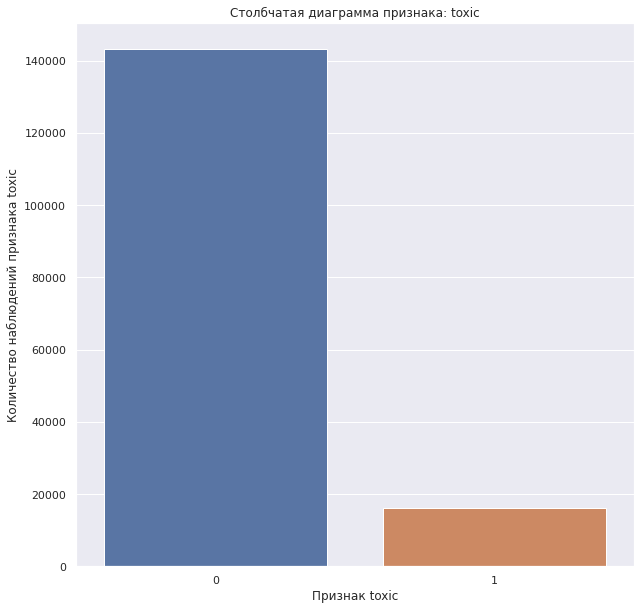

In [7]:
sns.set(rc={"figure.figsize":(10, 10)}, font_scale=1)   

(sns.barplot(x=df['toxic'].value_counts().index, y=df['toxic'].value_counts())
     .set(title='Столбчатая диаграмма признака: toxic',
      xlabel='Признак toxic',
      ylabel='Количество наблюдений признака toxic'));
print(
    '''
    
Количество позитивных комментариев: {0}, Доля позитивных комментариев: {1}
Количество негативных комментариев: {2}, Доля негативных комментариев: {3}
    
    '''
      .format(df[df['toxic']==0]['toxic'].count(), 
              round(df[df['toxic']==0]['toxic'].count() / df.shape[0], 3), 
              df[df['toxic']==1]['toxic'].count(),
              round(df[df['toxic']==1]['toxic'].count() / df.shape[0], 3)))

In [8]:
max_len = 0
for text in df['text']:
    if len(text) > max_len:
        max_len = len(text)
max_len

5000

In [9]:
corpus = df['text']

In [10]:
corpus.head(5)

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: text, dtype: object

Лемматизируем и очистим тексты

In [11]:
lemmatizer = WordNetLemmatizer()
def lemma_cleaner_func(text):
    cleaned = (' '.join(re.sub(r"[^a-zA-Z'\/]", ' ', text).split()))
    lemmatized = ' '.join([lemmatizer.lemmatize(word) for word in cleaned.split()])
    return lemmatized

In [12]:
corpus_final = corpus.apply(lambda x: lemma_cleaner_func(x))

In [13]:
pd.DataFrame(corpus_final.head(5))

,text
0,Explanation Why the edits made under my userna...
1,D'aww He match this background colour I'm seem...
2,Hey man I'm really not trying to edit war It's...
3,More I can't make any real suggestion on impro...
4,You sir are my hero Any chance you remember wh...


In [14]:
stopwords = set(stopwords.words('english'))

Создаем два типа векторизации строк - мешок слов и tf-idf. Для обоих типов создадим 2-граммы.

**Выводы по пункту 1:**

- Общее количество наблюдений: 159571
- Пропусков и дубликатов нет.
- Максимальная длина комментария: 5000 символов.
- Количество позитивных комментариев: 143346, Доля позитивных комментариев: 0.898
- Количество негативных комментариев: 16225, Доля негативных комментариев: 0.102
- Данные несбалансированы, отношение позитивных комментариев к негативным 9 к 1.
- Очистили корпус от лишних символов и лемматизировали его

## Обучение

In [15]:
class data_framework:
    '''
    Описание методов:
    1. data_split - деление данных на обучающую и тестовую выборку
    2. train_test_models - векторизирует данные, подбирает оптимальные гиперпараметры, тестирует оптимальную модель
    '''
    
    def __init__(self, corpus, toxic, model_name_list, vectorizer_name_list):

        self.corpus = corpus.copy(deep = True)
        self.toxic = toxic.copy(deep = True)
        self.toxic = self.toxic.astype('float')
        self.vectorizer_name_list = vectorizer_name_list
        self.model_name_list = model_name_list
        self.data_split()
        self.train_test_models()
        
    def data_split(self):
        
        self.features_train, self.features_test, self.target_train, self.target_test = train_test_split(self.corpus, self.toxic, test_size = 0.2, random_state=12345)

        print('Размер обучающей выборки: {0}|{1}'.format(self.features_train.shape, self.target_train.shape))
        print('Размер тестовой выборки: {0}|{1}'.format(self.features_test.shape, self.target_test.shape))
        

     
    def train_test_models(self):
        
        self.valid_table = pd.DataFrame({'Vectorizer' : [],
                                          'Model' : [],
                                          'Params' : [],
                                          'f1_score' : []})
        self.test_table = pd.DataFrame({'Vectorizer' : [],
                                          'Model' : [],
                                          'Params' : [],
                                          'f1_test_score' : []})
        
        
        for vectorizer_name in tqdm(self.vectorizer_name_list):
            
            if (vectorizer_name == 'count_vect'):
                vectorizer = CountVectorizer(stop_words = stopwords, dtype=np.float64)
            elif (vectorizer_name == 'count_vect_two_gram'):
                vectorizer = CountVectorizer(stop_words = stopwords, ngram_range=(1,2), dtype=np.float64)
            elif (vectorizer_name == 'count_tf_idf'):
                vectorizer = TfidfVectorizer(stop_words = stopwords, dtype=np.float64)
            elif (vectorizer_name == 'count_tf_idf_two_gram'):
                vectorizer = TfidfVectorizer(stop_words = stopwords, ngram_range=(1,2), dtype=np.float64)
                   
            self.f_train_vectorized = vectorizer.fit_transform(self.features_train).astype('float')
            self.f_test_vectorized = vectorizer.transform(self.features_test).astype('float')
            
            print(f"Размер векторизированного текста ({vectorizer_name}) обучающей выборки {self.f_train_vectorized.shape}")
            print(f"Размер векторизированного текста ({vectorizer_name}) тестовой выборки {self.f_test_vectorized.shape}")
            
            for model_name in self.model_name_list:
                
                if (model_name == 'LogisticRegression'):
                    model = LogisticRegression()
                    grid = {'model__C' : range(5,12,3)}
                elif (model_name == 'LightGBM'):
                    model = LGBMClassifier()
                    grid = {'model__n_estimators' : range(100,250,100)}
                pipeline_model = Pipeline([('vectorizer', vectorizer),
                                          ('model', model)])
                #valid-part    
                gridSearch = GridSearchCV(estimator=pipeline_model, param_grid=grid, cv=4, scoring='f1')
                gridSearch.fit(self.features_train, self.target_train)
                #gridSearch.fit(self.f_train_vectorized, self.target_train)
             

                print(f"Лучший результат модели {model_name} при кросс-валидации: f1 = {gridSearch.best_score_:.3f}")
                print(f"Лучшие гиперпараметры модели {model_name} при кросс-валидации: {gridSearch.best_params_}")
                self.valid_table = self.valid_table.append({'Vectorizer' : vectorizer_name,
                                          'Model' : model_name,
                                          'Params' : gridSearch.best_params_,
                                          'f1_score' : round(gridSearch.best_score_, 2)}, ignore_index=True)
                #test-part
                if (model_name == 'LogisticRegression'):
                    gridSearch.best_params_['C'] = gridSearch.best_params_.pop('model__C')
                    model_test = LogisticRegression(**gridSearch.best_params_)
                elif (model_name == 'LightGBM'):
                    gridSearch.best_params_['n_estimators'] = gridSearch.best_params_.pop('model__n_estimators')
                    model_test = LGBMClassifier(**gridSearch.best_params_)
                model_test.fit(self.f_train_vectorized, self.target_train)
                predictions = model_test.predict(self.f_test_vectorized)
                f1_test_score = f1_score(self.target_test, predictions)
                print(f"Тестовый результат модели {model_name}: f1 = {f1_test_score:.3f}")
                self.test_table = self.test_table.append({'Vectorizer' : vectorizer_name,
                                         'Model' : model_name,
                                         'Params' : gridSearch.best_params_,
                                         'f1_test_score' : round(f1_test_score, 2)}, ignore_index=True)

        #display(self.valid_table)
        display(self.test_table)
        

In [16]:
counter_vect_class = data_framework(corpus_final,
                        df['toxic'],
                        ['LogisticRegression', 'LightGBM'],
                       ['count_vect', 'count_vect_two_gram'])

Размер обучающей выборки: (127656,)|(127656,)
Размер тестовой выборки: (31915,)|(31915,)


  0%|          | 0/2 [00:00<?, ?it/s]

Размер векторизированного текста (count_vect) обучающей выборки (127656, 144355)
Размер векторизированного текста (count_vect) тестовой выборки (31915, 144355)
Лучший результат модели LogisticRegression при кросс-валидации: f1 = 0.762
Лучшие гиперпараметры модели LogisticRegression при кросс-валидации: {'model__C': 5}
Тестовый результат модели LogisticRegression: f1 = 0.768
Лучший результат модели LightGBM при кросс-валидации: f1 = 0.754
Лучшие гиперпараметры модели LightGBM при кросс-валидации: {'model__n_estimators': 200}


 50%|█████     | 1/2 [26:12<26:12, 1572.67s/it]

Тестовый результат модели LightGBM: f1 = 0.752
Размер векторизированного текста (count_vect_two_gram) обучающей выборки (127656, 2275887)
Размер векторизированного текста (count_vect_two_gram) тестовой выборки (31915, 2275887)
Лучший результат модели LogisticRegression при кросс-валидации: f1 = 0.772
Лучшие гиперпараметры модели LogisticRegression при кросс-валидации: {'model__C': 11}
Тестовый результат модели LogisticRegression: f1 = 0.777
Лучший результат модели LightGBM при кросс-валидации: f1 = 0.753
Лучшие гиперпараметры модели LightGBM при кросс-валидации: {'model__n_estimators': 200}


100%|██████████| 2/2 [1:38:51<00:00, 2965.51s/it]

Тестовый результат модели LightGBM: f1 = 0.752


,Vectorizer,Model,Params,f1_test_score
0,count_vect,LogisticRegression,{'C': 5},0.77
1,count_vect,LightGBM,{'n_estimators': 200},0.75
2,count_vect_two_gram,LogisticRegression,{'C': 11},0.78
3,count_vect_two_gram,LightGBM,{'n_estimators': 200},0.75


In [17]:
tf_idf_class = data_framework(corpus_final,
                        df['toxic'],
                        ['LogisticRegression', 'LightGBM'],
                       ['count_tf_idf', 'count_tf_idf_two_gram'])

Размер обучающей выборки: (127656,)|(127656,)
Размер тестовой выборки: (31915,)|(31915,)


  0%|          | 0/2 [00:00<?, ?it/s]

Размер векторизированного текста (count_tf_idf) обучающей выборки (127656, 144355)
Размер векторизированного текста (count_tf_idf) тестовой выборки (31915, 144355)
Лучший результат модели LogisticRegression при кросс-валидации: f1 = 0.771
Лучшие гиперпараметры модели LogisticRegression при кросс-валидации: {'model__C': 11}
Тестовый результат модели LogisticRegression: f1 = 0.780
Лучший результат модели LightGBM при кросс-валидации: f1 = 0.762
Лучшие гиперпараметры модели LightGBM при кросс-валидации: {'model__n_estimators': 200}


 50%|█████     | 1/2 [47:30<47:30, 2850.20s/it]

Тестовый результат модели LightGBM: f1 = 0.759
Размер векторизированного текста (count_tf_idf_two_gram) обучающей выборки (127656, 2275887)
Размер векторизированного текста (count_tf_idf_two_gram) тестовой выборки (31915, 2275887)
Лучший результат модели LogisticRegression при кросс-валидации: f1 = 0.768
Лучшие гиперпараметры модели LogisticRegression при кросс-валидации: {'model__C': 11}
Тестовый результат модели LogisticRegression: f1 = 0.778
Лучший результат модели LightGBM при кросс-валидации: f1 = 0.770
Лучшие гиперпараметры модели LightGBM при кросс-валидации: {'model__n_estimators': 200}


100%|██████████| 2/2 [2:27:49<00:00, 4434.57s/it]

Тестовый результат модели LightGBM: f1 = 0.763


,Vectorizer,Model,Params,f1_test_score
0,count_tf_idf,LogisticRegression,{'C': 11},0.78
1,count_tf_idf,LightGBM,{'n_estimators': 200},0.76
2,count_tf_idf_two_gram,LogisticRegression,{'C': 11},0.78
3,count_tf_idf_two_gram,LightGBM,{'n_estimators': 200},0.76


**Выводы по пункту 2**:

- Точность моделей с данными, векторизированными count_tf_idf (из таблицы выше: 0.78, 0.76, 0.78, 0.76) незначительно выше точности моделей с данными, векторизированными count_vect (из таблицы выше: 0.77, 0.75, 0.78, 0.75). 
- Точность моделей с данными, векторизированными 1-граммами (для tfidf: 0.78, 0.76) примерно равна точности моделей с данными, векторизированными 2-граммами (для tfidf: 0.78, 0.76)
- Время на обучение при использовании векторизацию tf_idf (148 минут) значительно выше, чем при векторизации count_vect (99 минут)
- Для всех полученных комбинаций f1_score > 0.75. Для модели LightGBM следует расширить сетку перебираемых параметров для получения бОльшего скора.
- Лучший тестовый f1-score = 0.78 для модели LogisticRegression

## Выводы

**Выводы по подготовке данных:**

- Общее количество наблюдений: 159571
- Пропусков и дубликатов нет.
- Максимальная длина комментария: 5000 символов.
- Количество позитивных комментариев: 143346, Доля позитивных комментариев: 0.898
- Количество негативных комментариев: 16225, Доля негативных комментариев: 0.102
- Данные несбалансированы, отношение позитивных комментариев к негативным 9 к 1.
- Очистили корпус от лишних символов и лемматизировали его

**Выводы по результатам обучения и тестирования:**

- Точность моделей с данными, векторизированными count_tf_idf (из таблицы выше: 0.78, 0.76, 0.78, 0.76) незначительно выше точности моделей с данными, векторизированными count_vect (из таблицы выше: 0.77, 0.75, 0.78, 0.75). 
- Точность моделей с данными, векторизированными 1-граммами (для tfidf: 0.78, 0.76) примерно равна точности моделей с данными, векторизированными 2-граммами (для tfidf: 0.78, 0.76)
- Время на обучение при использовании векторизацию tf_idf (148 минут) значительно выше, чем при векторизации count_vect (99 минут)
- Для всех полученных комбинаций f1_score > 0.75. Для модели LightGBM следует расширить сетку перебираемых параметров для получения бОльшего скора.
- Лучший тестовый f1-score = 0.78 для модели LogisticRegression